In [1]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import cv2

In [2]:
target_dir = '../../DATA/DLC'
if os.path.exists(target_dir):
    print('target dir exists')
else:
    print('target dir does not exist')

path_video = r'D:\Octopus_OdorTracking\DATA\sinlge_target_experiment_trajs__400_220_1550_965\khorne\10_43-0\khorne_10_43-0_ff.mp4'
if os.path.exists(path_video):
    print('video exists')
else:
    print('video does not exist')

target dir exists
video exists


In [3]:
frames = []
cap = cv2.VideoCapture(path_video)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    else:
        break
cap.release()
frames = np.array(frames)

In [4]:
end_frame = int(0.6 * frames.shape[0])
subsample = 80
frames_ss = frames[:end_frame][::subsample]
std_ss = np.std(frames_ss, axis=0)

In [5]:
## get idxs of frames subsampled
idxs = []
for i in range(0, end_frame, subsample):
    idxs.append(i)

In [6]:
def given_xy_xy_get_bodyaxis_angle(x1, y1, x2, y2):
    '''
    given two points, get the angle of the body axis
    '''
    dx = x2 - x1
    dy = y2 - y1
    angle = np.arctan2(dy, dx)
    angle = angle - np.pi/2

    return np.array(angle)

def given_dx_dy_get_velocity_angle(dx, dy):
    '''
    given two points, get the angle of the body axis
    '''
    angle = np.arctan2(dy, dx)
    angle = angle

    return np.array(angle)

path_df = glob.glob(os.path.join(os.path.dirname(path_video), '*_ff.h5'))[0]
df = pd.read_hdf(path_df)

lex = df[df.columns[9]]
ley = df[df.columns[10]]
rex = df[df.columns[12]]
rey = df[df.columns[13]]
angle = given_xy_xy_get_bodyaxis_angle(lex, ley, rex, rey)
df['angle'] = angle

mex = (lex + rex) / 2
mey = (ley + rey) / 2
dx = np.diff(mex)
dy = np.diff(mey)

df = df.iloc[:-1]
df['dx'] = dx
df['dy'] = dy
angle_vel = given_dx_dy_get_velocity_angle(dx, dy)
df['angle_vel'] = angle_vel

## calculate unit vector of body axis
df['uvec_x'] = np.cos(df['angle']) ## x unit vector
df['uvec_y'] = np.sin(df['angle']) ## y unit vector

## calculate unit vector of velocity
df['uvec_vel_x'] = np.cos(df['angle_vel']) ## x unit vector
df['uvec_vel_y'] = np.sin(df['angle_vel']) ## y unit vector

# calculate dot product between the two unit vectors
df['dot_product'] = df['uvec_x']*df['uvec_vel_x'] + df['uvec_y']*df['uvec_vel_y']

# calculate the angle between the two unit vectors using arccos
df['angle_between'] = np.arccos(df['dot_product'].clip(-1, 1))


In [7]:
## subsample df to match frames
df_ss = df.iloc[idxs]
## reset index
df_ss = df_ss.reset_index(drop=True)
print(df.columns)
print(df.shape)

MultiIndex([(                                  'crop-x',          '', ...),
            (                                  'crop-y',          '', ...),
            (                                 'crop-xr',          '', ...),
            (                                 'crop-yr',          '', ...),
            (                              'movie_path',          '', ...),
            (                                'datetime',          '', ...),
            (                        'frame in ffmovie',          '', ...),
            (                           'bbox_in0_out1',          '', ...),
            (                               'seq-inout',          '', ...),
            ('DLC_resnet50_ffmodelOct20shuffle1_500000',   'lefteye', ...),
            ('DLC_resnet50_ffmodelOct20shuffle1_500000',   'lefteye', ...),
            ('DLC_resnet50_ffmodelOct20shuffle1_500000',   'lefteye', ...),
            ('DLC_resnet50_ffmodelOct20shuffle1_500000',  'righteye', ...),
            

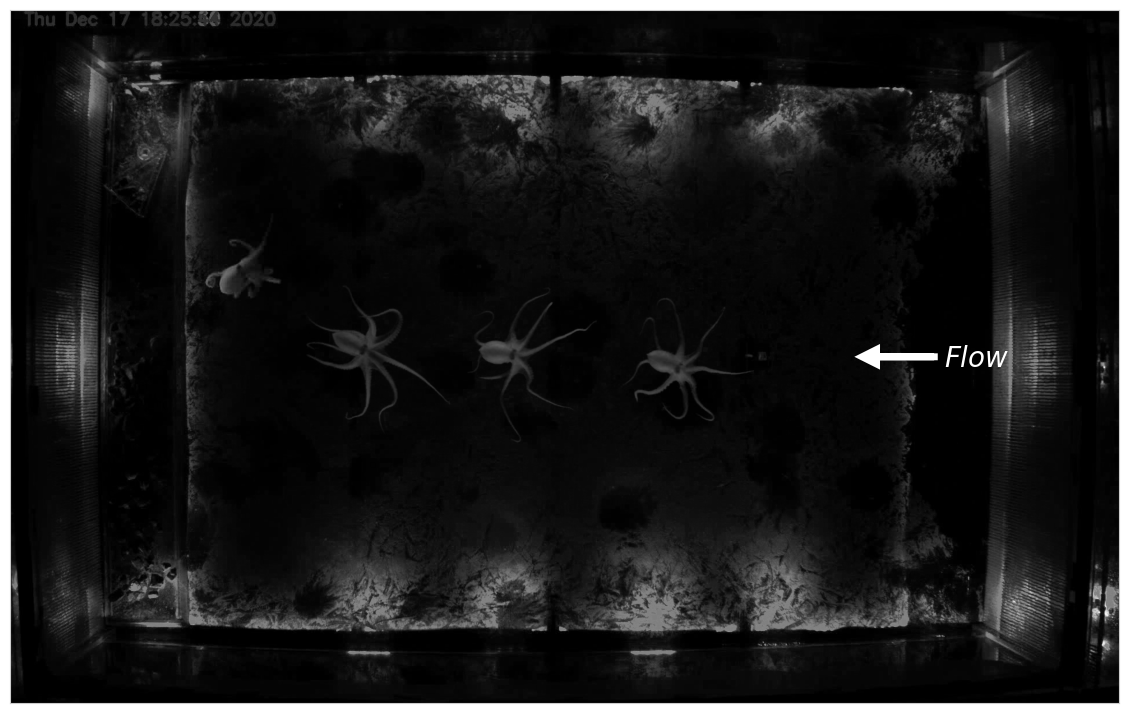

In [8]:
## plot std image
fig, ax = plt.subplots(1,1, figsize=(18,9))

ax.imshow(frames[0], zorder=1, cmap='Greys_r')
ax.imshow(std_ss, zorder=1, cmap='Greys_r', alpha=0.5)

ax.set_xticks([])
ax.set_yticks([])

## add an arrow to the plot denoting the direction of flow
ax.arrow(1600, 600, -100, 0, linewidth=5, zorder=3, head_width=25, head_length=25, color = 'white')
#ax.arrow(1595, 600, -98, 0, linewidth=3, zorder=3, head_width=23, head_length=23, color = '#1C95FF')

## add text behind the arrow
ax.text(1730, 605, '$\\it{Flow}$', fontsize=20, color='white', zorder=2, ha='right', va='center')

path_figure = os.path.join(target_dir, 'make_dlc_figure__ghostplot.png')
fig.savefig(path_figure, dpi=300, bbox_inches='tight', pad_inches=0.5)

plt.show(fig)
plt.close(fig)

C:\Users\wlwee\AppData\Local\Temp\ipykernel_4532\2824987844.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle = row['angle'][0]
C:\Users\wlwee\AppData\Local\Temp\ipykernel_4532\2824987844.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle_vel = row['angle_vel'][0]
C:\Users\wlwee\AppData\Local\Temp\ipykernel_4532\2824987844.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arc_angle = np.degrees(row['angle_between

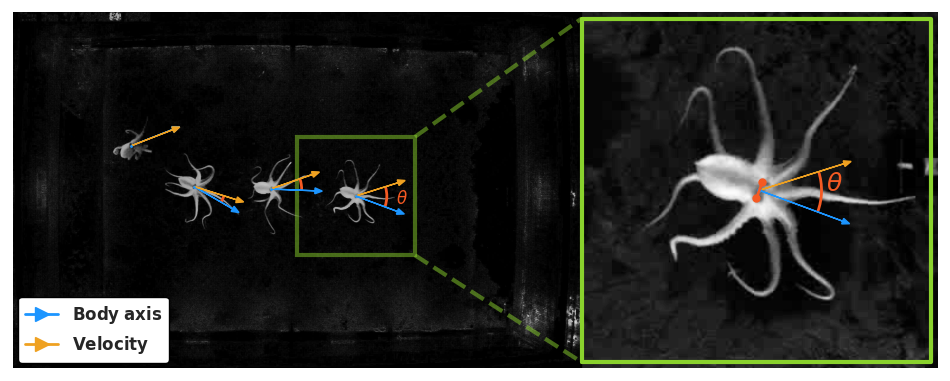

In [9]:
color_key = {'body_axis': '#1C95FF', 'velocity': '#EFA121', 'theta':'#F55A23', 'crop_edge':'#8AD22D'}

Bscalar = 150

fig, ax = plt.subplots(1,1, figsize=(12,6))

#ax.imshow(std_ss, zorder=1, cmap='Greys_r')
#ax.imshow(frames[0], zorder=1, cmap='Greys_r')
vmax = np.mean(std_ss) + 8*np.std(std_ss)
ax.imshow(std_ss, zorder=1, cmap='Greys_r', alpha=0.5, vmax=vmax)

xmin = 1920
xmax = 0
ymin = 1200
ymax = 0

crop_edge = 200
crop_frame = None

for i, row in df_ss.iterrows():
    lex = row[df.columns[9]]
    ley = row[df.columns[10]]
    rex = row[df.columns[12]]
    rey = row[df.columns[13]]
    mex = (lex + rex) / 2
    mey = (ley + rey) / 2

    if mex < xmin:
        xmin = mex
    if mex > xmax:
        xmax = mex
    if mey < ymin:
        ymin = mey
    if mey > ymax:
        ymax = mey

    ## plot body axis vector
    angle = row['angle'][0]

    center_x, center_y = mex, mey
    end_x = center_x + Bscalar * np.cos(angle)
    end_y = center_y + Bscalar * np.sin(angle)

    dx = end_x - center_x
    dy = end_y - center_y

    ax.scatter(mex, mey, color=color_key['body_axis'], s=1, zorder=4)

    ax.arrow(center_x, center_y, dx, dy, color=color_key['body_axis'], linewidth=1, zorder=3, head_width=20, head_length=25) # Adjust head_width and head_length as needed

    ## plot velocity vector
    angle_vel = row['angle_vel'][0]

    center_x, center_y = mex, mey
    end_x = center_x + Bscalar * np.cos(angle_vel)
    end_y = center_y + Bscalar * np.sin(angle_vel)

    dx = end_x - center_x
    dy = end_y - center_y

    ax.arrow(center_x, center_y, dx, dy, color=color_key['velocity'], linewidth=1, zorder=3, head_width=20, head_length=25) # Adjust head_width and head_length as needed

    ## draw an arc between the two vectors using an arc of a circle ##
    angle_deg = np.degrees(angle)
    angle_vel_deg = np.degrees(angle_vel)
    arc_angle = np.degrees(row['angle_between'][0])

    if angle_vel_deg < angle_deg:
        theta_start = angle_vel_deg
        theta_end = angle_deg
    else:
        theta_start = angle_deg
        theta_end = angle_deg + arc_angle

    arc_radius = Bscalar * 0.7  # scale it to 90% of Bscalar; adjust as needed
    arc = Arc((center_x, center_y), 2*arc_radius, 2*arc_radius, angle=0, theta1=theta_start, theta2=theta_end, color=color_key['theta'], zorder=1, linewidth=2)
    ax.add_patch(arc)

    # Label for theta
    mid_angle_rad = np.radians((theta_start + theta_end) / 2)
    label_radius = arc_radius * 1.5  # label position a bit outside the arc
    label_x = center_x + label_radius * np.cos(mid_angle_rad)
    label_y = center_y + label_radius * np.sin(mid_angle_rad)

    if i == df_ss.shape[0] - 1:
        ax.text(label_x, label_y, f"$\\theta$", horizontalalignment='center', verticalalignment='center', fontsize=12, zorder=5, color=color_key['theta'], fontweight='bold')

    if i == df_ss.shape[0] - 1:
        crop_pad = 50
        crop_frame = frames[idxs[i]]
        crop_frame = crop_frame[int(center_y - crop_edge + crop_pad):int(center_y + crop_edge - crop_pad), int(center_x - crop_edge + crop_pad):int(center_x + crop_edge - crop_pad)]

    if i == df_ss.shape[0] - 1:
        ## draw 600x600 rectangle centered around center_x, center_y
        rect = patches.Rectangle((center_x-crop_edge, center_y-crop_edge), 2*crop_edge, 2*crop_edge, linewidth=3, edgecolor=color_key['crop_edge'], facecolor='none', zorder=2, alpha=0.5)
        ax.add_patch(rect)

        ## draw line from top right of rectangle to upper right corner of image
        ax.plot([center_x+crop_edge, 1920], [center_y-crop_edge, 0+20], color=color_key['crop_edge'], linewidth=3, zorder=2, alpha=0.5, linestyle='--')

        ## draw line from bottom right of rectangle to lower right corner of image
        ax.plot([center_x+crop_edge, 1920], [center_y+crop_edge, 1200-20], color=color_key['crop_edge'], linewidth=3, zorder=2, alpha=0.5, linestyle='--')

        ## draw line down the bottom right of the image
        ax.plot([1920, 1920], [1200-20, 0+20], color=color_key['crop_edge'], linewidth=3, zorder=2, alpha=1)

## resize crop_frame so it's y shape == std_ss y shape
crop_frame_rs = cv2.resize(crop_frame, (std_ss.shape[0], std_ss.shape[0]), interpolation=cv2.INTER_AREA)

base = np.hstack((std_ss, crop_frame_rs))
ax.imshow(base, zorder=0, cmap='Greys_r', alpha=1)

## draw a line around the crop_frame portion of base
ax.plot([1920, 1920+1200-20, 1920+1200-20, 1920], [0+20, 0+20, 1200-20, 1200-20], color=color_key['crop_edge'], linewidth=3, zorder=2, alpha=1)

## draw body axis and velocity vectors on the crop_frame portion of base for the last frame centered on 1920+600, 600
angle = df_ss['angle'][df_ss.shape[0]-1]
angle_vel = df_ss['angle_vel'][df_ss.shape[0]-1]

center_x, center_y = 1920+600, 600

Bscalar = 300

## plot body axis vector
end_x = center_x + Bscalar * np.cos(angle)
end_y = center_y + Bscalar * np.sin(angle)

dx = end_x - center_x
dy = end_y - center_y

ax.arrow(center_x, center_y, dx, dy, color=color_key['body_axis'], linewidth=1, zorder=4, head_width=20, head_length=25) # Adjust head_width and head_length as needed

ax.scatter(center_x, center_y, color=color_key['body_axis'], s=5, zorder=4)

Pscalar = 3.5
## draw line between lex-mex + 1920+600, ley-mey + 600 and rex-mex + 1920+600, rey-mey + 600
lex, ley = df_ss[df.columns[9]][df_ss.shape[0]-1], df_ss[df.columns[10]][df_ss.shape[0]-1]
lex = Pscalar*(lex-mex) + 1920+600
ley = Pscalar*(ley-mey) + 600
rex, rey = df_ss[df.columns[12]][df_ss.shape[0]-1], df_ss[df.columns[13]][df_ss.shape[0]-1]
rex = Pscalar*(rex-mex) + 1920+600
rey = Pscalar*(rey-mey) + 600

ax.plot([lex, rex], [ley, rey], linewidth=2, zorder=6, color=color_key['theta'], marker='o', markersize=5, markerfacecolor=color_key['theta'], markeredgecolor=color_key['theta'])

## plot velocity vector
end_x = center_x + Bscalar * np.cos(angle_vel)
end_y = center_y + Bscalar * np.sin(angle_vel)

dx = end_x - center_x
dy = end_y - center_y

ax.arrow(center_x, center_y, dx, dy, color=color_key['velocity'], linewidth=1, zorder=3, head_width=20, head_length=25) # Adjust head_width and head_length as needed

## draw the arc for theta
arc_radius = Bscalar * 0.7  # scale it to 90% of Bscalar; adjust as needed

arc_angle = np.degrees(angle_vel - angle)

if arc_angle < 0:
    theta_start = angle_vel_deg
    theta_end = angle_deg
else:
    theta_start = angle_deg
    theta_end = angle_deg + arc_angle

arc = Arc((center_x, center_y), 2*arc_radius, 2*arc_radius, angle=0, theta1=theta_start, theta2=theta_end, color=color_key['theta'], zorder=2, linewidth=2)
ax.add_patch(arc)

## draw theta
# Label for theta
mid_angle_rad = np.radians((theta_start + theta_end) / 2)+np.pi/65
label_radius = arc_radius * 1.3  # label position a bit outside the arc
label_x = center_x + label_radius * np.cos(mid_angle_rad)
label_y = center_y + label_radius * np.sin(mid_angle_rad)

ax.text(label_x-20, label_y-40, f"$\\theta$", horizontalalignment='center', verticalalignment='center', fontsize=18, zorder=5, color=color_key['theta'], fontweight='bold')

lines = [Line2D([0], [0], color=color_key['body_axis'], lw=2, linestyle='-', marker='>', markersize=10, markerfacecolor=color_key['body_axis']),
         Line2D([0], [0], color=color_key['velocity'], lw=2, linestyle='-', marker='>', markersize=10, markerfacecolor=color_key['velocity'])]
labels = ['$\\bf{Body}$ $\\bf{axis}$', '$\\bf{Velocity}$']
leg = ax.legend(lines, labels, loc='lower left', fontsize=12, frameon=True, framealpha=1, edgecolor='black', facecolor='white', bbox_to_anchor=(0, 0.0))

xlim = (0-10, 1920 + 1200+10)
ylim = (1210, -10)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_aspect('equal')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

path_figure = os.path.join(target_dir, 'make_dlc_figure__ghostplot_body_axis_velocity_theta.png')
fig.savefig(path_figure, dpi=300, bbox_inches='tight', pad_inches=0.5)

plt.show(fig)
plt.close(fig)

In [25]:
path_arms_model_eval_results = os.path.join(target_dir, 'fcmodel', 'CombinedEvaluation-results-comb-dat.csv')
df_arms = pd.read_csv(path_arms_model_eval_results)
df_arms

,Unnamed: 0,Training iterations:,%Training dataset,Shuffle number,Train error(px),Test error(px),p-cutoff used,Train error with p-cutoff,Test error with p-cutoff,bodypart
0,0,50000,70,1,18.08,23.16,0.4,15.88,19.39,all
1,1,100000,70,1,9.16,17.39,0.4,8.14,15.47,all
2,2,150000,70,1,5.41,14.58,0.4,4.89,12.01,all
3,3,200000,70,1,3.53,12.69,0.4,3.35,10.68,all
4,4,250000,70,1,3.05,12.77,0.4,2.87,10.54,all
5,5,300000,70,1,2.84,12.94,0.4,2.71,11.02,all
6,6,350000,70,1,2.54,11.72,0.4,2.39,10.13,all
7,7,400000,70,1,2.62,13.03,0.4,2.52,10.88,all
8,8,450000,70,1,1.86,11.19,0.4,1.85,9.42,all
9,9,500000,70,1,1.78,11.24,0.4,1.77,9.40,all


In [26]:
path_eyes_model_eval_results = os.path.join(target_dir, 'ffmodel', 'CombinedEvaluation-results-comb.csv')
df_eyes = pd.read_csv(path_eyes_model_eval_results)
df_eyes

,Unnamed: 0,Training iterations:,%Training dataset,Shuffle number,Train error(px),Test error(px),p-cutoff used,Train error with p-cutoff,Test error with p-cutoff,bodypart
0,0,50000,70,1,20.14,24.06,0.6,14.72,17.78,all
1,1,100000,70,1,5.83,13.33,0.6,4.88,7.95,all
2,2,150000,70,1,5.00,9.50,0.6,4.91,7.69,all
3,3,200000,70,1,3.06,9.14,0.6,3.00,5.67,all
4,4,250000,70,1,2.82,6.18,0.6,2.82,5.88,all
5,5,300000,70,1,2.96,6.81,0.6,2.96,6.17,all
6,6,350000,70,1,3.86,10.05,0.6,3.82,9.78,all
7,7,400000,70,1,2.42,5.83,0.6,2.43,5.29,all
8,8,450000,70,1,2.12,5.57,0.6,2.12,5.16,all
9,9,500000,70,1,2.01,5.59,0.6,2.01,5.32,all


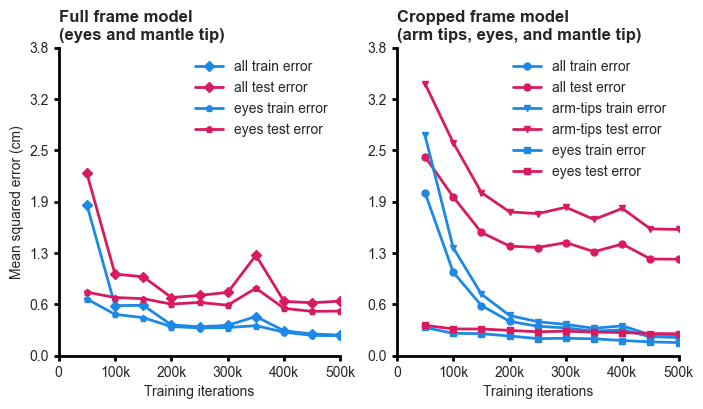

In [185]:

fig, axs = plt.subplots(1, 2, figsize=(8,4))

xlim = (0, 500000)
ylim = (0, 30)

y_value_correction_ = 2.54/20
yticks = np.arange(0, 35, 5)
y_value_correction_ = 2.54/20 ## convert pixels to cm; 20 pixels = 1inch = 2.54cm
ylabels = np.round(yticks * y_value_correction_,1)

xticks = [0, 100000, 200000, 300000, 400000, 500000]
xlabs = ['0', '100k', '200k', '300k', '400k', '500k']

## visualize the evaluation results of the arm model
unique_bodypart_splits = df_arms['bodypart'].unique()
train_color = '#1E88E5'
test_color = '#D81B60'

## map unique body parts to differeny symbols
symbols = ['o', 'v', 's']
symbol_dict = dict(zip(unique_bodypart_splits, symbols))

marker_size = 5
linewidth = 2

ax = axs[1]

lines_for_legend = []
for bodypart in unique_bodypart_splits:
    df_bp = df_arms[df_arms['bodypart'] == bodypart]
    x = df_bp['Training iterations:']
    y_test = df_bp['Test error with p-cutoff']
    y_train = df_bp['Train error with p-cutoff']

    symbol = symbol_dict[bodypart]
    ax.plot(x, y_train, color=train_color, marker=symbol, markersize=marker_size, linewidth=linewidth)
    ax.plot(x, y_test, color=test_color, marker=symbol, markersize=marker_size, linewidth=linewidth)

    lines_for_legend.append(Line2D([0], [0], color=train_color, marker=symbol, markersize=marker_size, linestyle='-', linewidth=linewidth, label=f'{bodypart} train error'))
    lines_for_legend.append(Line2D([0], [0], color=test_color, marker=symbol, markersize=marker_size, linestyle='-', linewidth=linewidth, label=f'{bodypart} test error'))

ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='black', width=2)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='black', width=2)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')

## set up custom legend
ax.legend(lines_for_legend, [line.get_label() for line in lines_for_legend], loc='upper right', fontsize=10, frameon=False, framealpha=1, edgecolor='black', facecolor='white')

ax.set_xlabel('Training iterations')

ax.set_title('Cropped frame model\n(arm tips, eyes, and mantle tip)', loc='left', fontsize=12, fontweight='bold')

##################################################
## visualize the evaluation results of the eye model
unique_bodypart_splits = df_eyes['bodypart'].unique()
train_color = '#1E88E5'
test_color = '#D81B60'

## map unique body parts to differeny symbols
symbols = ['D', 'p', 'h']
symbol_dict = dict(zip(unique_bodypart_splits, symbols))

ax = axs[0]

lines_for_legend = []
for bodypart in unique_bodypart_splits:
    df_bp = df_eyes[df_eyes['bodypart'] == bodypart]
    x = df_bp['Training iterations:']
    y_test = df_bp['Test error with p-cutoff']
    y_train = df_bp['Train error with p-cutoff']

    symbol = symbol_dict[bodypart]
    ax.plot(x, y_train, color=train_color, marker=symbol, markersize=marker_size, linewidth=linewidth)
    ax.plot(x, y_test, color=test_color, marker=symbol, markersize=marker_size, linewidth=linewidth)

    lines_for_legend.append(Line2D([0], [0], color=train_color, marker=symbol, markersize=marker_size, linestyle='-', linewidth=linewidth, label=f'{bodypart} train error'))
    lines_for_legend.append(Line2D([0], [0], color=test_color, marker=symbol, markersize=marker_size, linestyle='-', linewidth=linewidth, label=f'{bodypart} test error'))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='black', width=2)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='black', width=2)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')

## turn off grid
ax.grid(False)

ax.set_ylabel('Mean squared error (cm)')
ax.set_xlabel('Training iterations')

ax.set_title('Full frame model\n(eyes and mantle tip)', loc='left', fontsize=12, fontweight='bold')

## set up custom legend
ax.legend(lines_for_legend, [line.get_label() for line in lines_for_legend], loc='upper right', fontsize=10, frameon=False, framealpha=1, edgecolor='black', facecolor='white')

path_fig = os.path.join(target_dir, 'make_dlc_figure__model_eval.png')
fig.savefig(path_fig, dpi=300, bbox_inches='tight', pad_inches=0.5)

plt.show(fig)
plt.close(fig)

In [127]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

def apply_savgol_filter(x, y, window_size=29, poly_degree=5):
    """
    Apply Savitzky-Golay filter to smooth 2D pose estimation data.

    Parameters:
    - x, y: Arrays containing the x and y coordinates of the pose estimation data
    - window_size: The window size for the Savitzky-Golay filter (must be odd and >= poly_degree + 1)
    - poly_degree: The polynomial degree for the Savitzky-Golay filter

    Returns:
    - smoothed_x, smoothed_y: Arrays containing the smoothed x and y coordinates
    """

    # Check if the window size and polynomial degree are compatible
    if window_size % 2 == 0 or window_size < poly_degree + 1:
        return "Invalid window size or polynomial degree"

    # Apply Savitzky-Golay filter
    smoothed_x = savgol_filter(x, window_size, poly_degree)
    smoothed_y = savgol_filter(y, window_size, poly_degree)

    return smoothed_x, smoothed_y

def detect_outliers_statistical(x, y, window_size=40, k=3.0):
    """
    Detect outliers in 2D pose estimation data based on a moving window statistical method.

    Parameters:
    - x, y: Arrays containing the x and y coordinates of the pose estimation data
    - window_size: The window size for calculating mean and std deviation (should be odd)
    - k: The factor for defining the threshold based on std deviation

    Returns:
    - outlier_indices: List of indices where outliers are located
    """

    # Ensure window_size is odd for symmetry
    if window_size % 2 == 0:
        window_size += 1

    half_window = window_size // 2
    n = len(x)

    outlier_indices = []

    for i in range(n):
        # Define the window boundaries
        start_idx = max(0, i - half_window)
        end_idx = min(n, i + half_window + 1)

        # Extract window data
        x_window = x[start_idx:end_idx]
        y_window = y[start_idx:end_idx]

        # Calculate mean and standard deviation for x and y
        mean_x = np.mean(x_window)
        mean_y = np.mean(y_window)

        std_x = np.std(x_window)
        std_y = np.std(y_window)

        # Check if the point is an outlier
        if abs(x[i] - mean_x) > k * std_x or abs(y[i] - mean_y) > k * std_y:
            outlier_indices.append(i)

    return outlier_indices

def impute_outliers(x, y, outlier_indices):
    """
    Robustly impute outliers in 2D pose estimation data using linear interpolation between valid regions.

    Parameters:
    - x, y: Arrays containing the x and y coordinates of the pose estimation data
    - outlier_indices: List of indices where outliers are located

    Returns:
    - imputed_x, imputed_y: Arrays containing the imputed x and y coordinates
    """

    # Initialize imputed arrays with original data
    imputed_x = np.array(x)
    imputed_y = np.array(y)

    # Create a boolean mask where True indicates an outlier
    outlier_mask = np.zeros(len(x), dtype=bool)
    outlier_mask[outlier_indices] = True

    # Find valid regions in the data
    valid_regions = []
    start_idx = 0
    for i in range(1, len(x)):
        if outlier_mask[i] and not outlier_mask[i-1]:
            end_idx = i
            valid_regions.append((start_idx, end_idx))
        elif not outlier_mask[i] and outlier_mask[i-1]:
            start_idx = i

    if not outlier_mask[-1]:
        valid_regions.append((start_idx, len(x)))

    # Perform interpolation based on valid regions
    for i in range(len(valid_regions) - 1):
        start_idx1, end_idx1 = valid_regions[i]
        start_idx2, end_idx2 = valid_regions[i+1]

        interp_func_x = interp1d([end_idx1, start_idx2], [x[end_idx1-1], x[start_idx2]], kind='linear')
        interp_func_y = interp1d([end_idx1, start_idx2], [y[end_idx1-1], y[start_idx2]], kind='linear')

        imputed_x[end_idx1:start_idx2] = interp_func_x(np.arange(end_idx1, start_idx2))
        imputed_y[end_idx1:start_idx2] = interp_func_y(np.arange(end_idx1, start_idx2))

    return imputed_x, imputed_y

In [152]:
## now we are going to make a figure that shows a side by side of tracking of the full frame and cropped frame results with and w/o savgol smoothing
path_example_dir = os.path.join(target_dir, 'kratos_example')
os.listdir(path_example_dir)

['.DS_Store',
 'fc__kratos__2020_12_2020__18_19_45_700__7__6000.csv',
 'fc__kratos__2020_12_2020__18_19_45_700__7__6000.mp4',
 'fc__kratos__2020_12_2020__18_19_45_700__7__6000DLC_resnet50_armsJan17shuffle1_1000000.h5',
 'fc__kratos__2020_12_2020__18_19_45_700__7__6000DLC_resnet50_armsJan17shuffle1_1000000_filtered.h5',
 'fc__kratos__2020_12_2020__18_19_45_700__7__6000DLC_resnet50_armsJan17shuffle1_1000000_filtered_labeled.mp4',
 'fc__kratos__2020_12_2020__18_19_45_700__7__6000DLC_resnet50_armsJan17shuffle1_1000000_meta.pickle',
 'kratos__2020_12_2020__18_19_45_700__7__6000.mp4',
 'kratos__2020_12_2020__18_19_45_700__7__6000.png']

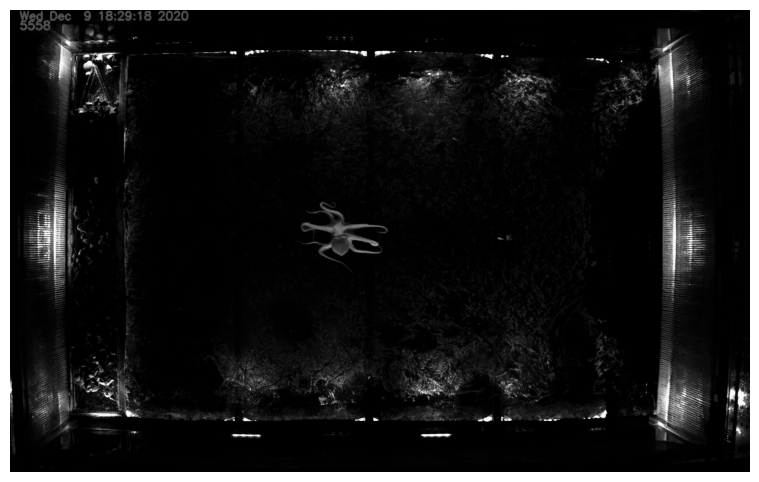

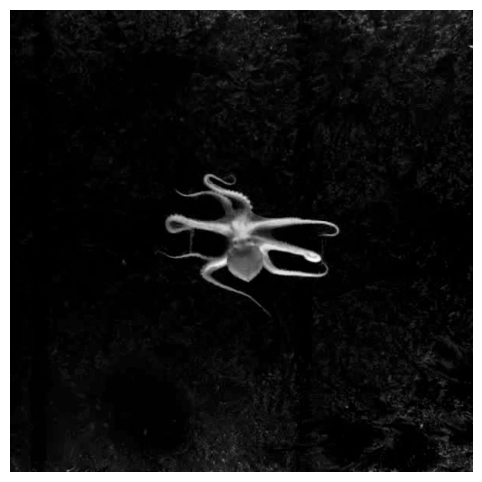

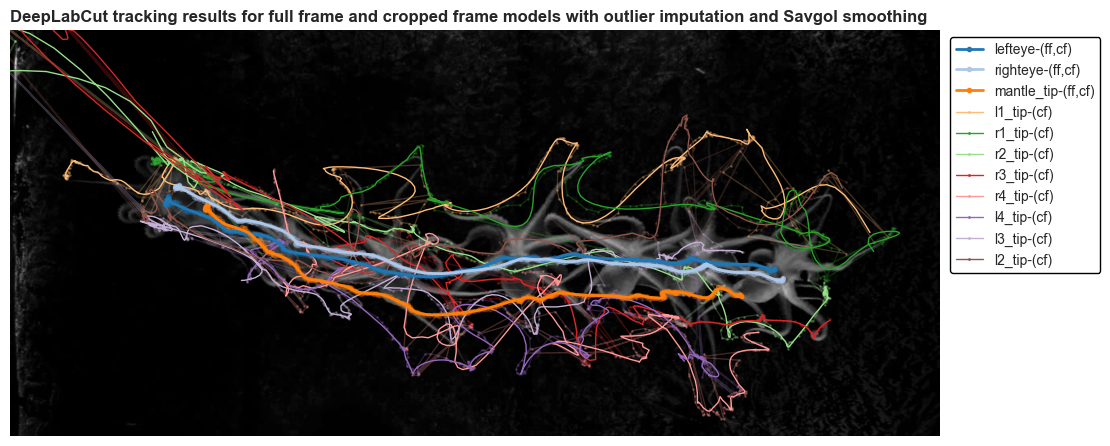

In [188]:
path_labels = os.path.join(path_example_dir, 'fc__kratos__2020_12_2020__18_19_45_700__7__6000DLC_resnet50_armsJan17shuffle1_1000000.h5')
df_labels = pd.read_hdf(path_labels)

path_labels_shift_meta = os.path.join(path_example_dir, 'fc__kratos__2020_12_2020__18_19_45_700__7__6000.csv')
df_labels_shift_meta = pd.read_csv(path_labels_shift_meta)

path_video = os.path.join(path_example_dir, 'kratos__2020_12_2020__18_19_45_700__7__6000.mp4')
cap = cv2.VideoCapture(path_video)
l = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_range = (50, 400)
## save a single frame at the middle of the frame range
save_frame = int(np.mean(frame_range))
cap.set(cv2.CAP_PROP_POS_FRAMES, save_frame)
ret, saved_frame = cap.read()
if ret:
    saved_frame = cv2.cvtColor(saved_frame, cv2.COLOR_BGR2GRAY)
    path_saved_frame = os.path.join(target_dir, 'ff_model_input_frame.png')
    cv2.imwrite(path_saved_frame, saved_frame)

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.imshow(saved_frame, cmap='Greys_r')
ax.grid(False)
ax.axis('off')

plt.show(fig)
plt.close(fig)

xshift, yshift = df_labels_shift_meta['x'].values, df_labels_shift_meta['y'].values

for xcol, ycol in zip(df_labels.columns[::3], df_labels.columns[1::3]):
    #print(xcol, ycol)

    x, y = df_labels[xcol].values, df_labels[ycol].values

    x = x + xshift
    y = y + yshift

    df_labels[xcol] = x
    df_labels[ycol] = y

xle, yle = df_labels[df_labels.columns[0]].values, df_labels[df_labels.columns[1]].values
xre, yre = df_labels[df_labels.columns[3]].values, df_labels[df_labels.columns[4]].values
xme, yme = (xle + xre) / 2, (yle + yre) / 2

space_pad = 200
minx = np.min(xme)-space_pad
maxx = np.max(xme)+space_pad
miny = np.min(yme)-space_pad
maxy = np.max(yme)+space_pad

## save cropped frame of save_frame
x_xme, y_yme = int(xme[save_frame]), int(yme[save_frame])
crop_edge = 300
crop_frame = saved_frame[int(y_yme - crop_edge):int(y_yme + crop_edge),
             int(x_xme - crop_edge):int(x_xme + crop_edge)]
cv2.imwrite(os.path.join(target_dir, 'cf_model_input_frame.png'), crop_frame)

df_labels = df_labels.iloc[frame_range[0]:frame_range[1]]
df_labels_shift_meta = df_labels_shift_meta.iloc[frame_range[0]:frame_range[1]]

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.imshow(crop_frame, cmap='Greys_r')
ax.grid(False)
ax.axis('off')

plt.show(fig)
plt.close(fig)

xlim = (minx, maxx)
ylim = (maxy, miny)

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_range[0])

frames = []
for i in range(0, frame_range[1] - frame_range[0]):
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    else:
        break
cap.release()

frames = np.array(frames)

#print(f'shape frames: {frames.shape}')

## define colormap for df_labels.columns for each unique x,y pair
cols = []
for i in range(0, len(df_labels.columns), 3):
    cols.append(cm.tab20(i//3))

## subsample frames by subsample and then make a maxprojection
subsample = 49
frames_ss = frames[::subsample]
max_ss = np.max(frames_ss, axis=0)

linewidth = 1
marker = 'o'
marker_size = 2

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.imshow(max_ss, cmap='Greys_r', zorder=0)

n = 0
lines_for_legend = []
for xcol, ycol in zip(df_labels.columns[::3], df_labels.columns[1::3]):
    if 'tip' in xcol[1] and 'mantle' not in xcol[1]:
        alpha = 0.1
        linewidth = 1
        marker = 'o'
        marker_size = 1
        order = 2
        label = f'{xcol[1]}-(cf)'
    else:
        alpha = 0.5
        linewidth = 2
        marker = 'o'
        marker_size = 3
        order = 4
        label = f'{xcol[1]}-(ff,cf)'

    x, y = df_labels[xcol].values, df_labels[ycol].values

    ax.plot(x, y, color=cols[n], linewidth=linewidth, marker=marker, markersize=marker_size, markerfacecolor=cols[n], markeredgecolor=cols[n], alpha=0.25, zorder=order)

    ## smooth x,y using savgol filter
    detected_outliers_statistical = detect_outliers_statistical(x, y)
    imputed_x, imputed_y = impute_outliers(x, y, detected_outliers_statistical)
    smoothed_x, smoothed_y = apply_savgol_filter(imputed_x, imputed_y)

    ax.plot(smoothed_x, smoothed_y, color=cols[n], linewidth=linewidth, alpha=1, zorder=order+1)

    df_labels[xcol] = smoothed_x
    df_labels[ycol] = smoothed_y

    lines_for_legend.append(Line2D([0], [0], color=cols[n],
                                   linewidth=linewidth,
                                   marker=marker,
                                   markersize=marker_size, alpha=1,
                                   linestyle='-', label=label))

    n += 1

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.axis('off')
ax.grid(False)

ax.set_title('DeepLabCut tracking results for full frame and cropped frame models with outlier imputation and Savgol smoothing', loc='left', fontsize=12, fontweight='bold')

ax.legend(lines_for_legend, [line.get_label() for line in lines_for_legend], bbox_to_anchor=(1.18,1),
          loc='upper right', fontsize=10, frameon=True, framealpha=1, edgecolor='black', facecolor='white')

path_fig = os.path.join(target_dir, 'dlc_tracking_results.png')
fig.savefig(path_fig, dpi=300, bbox_inches='tight', pad_inches=0.5)

plt.show(fig)
plt.close(fig)

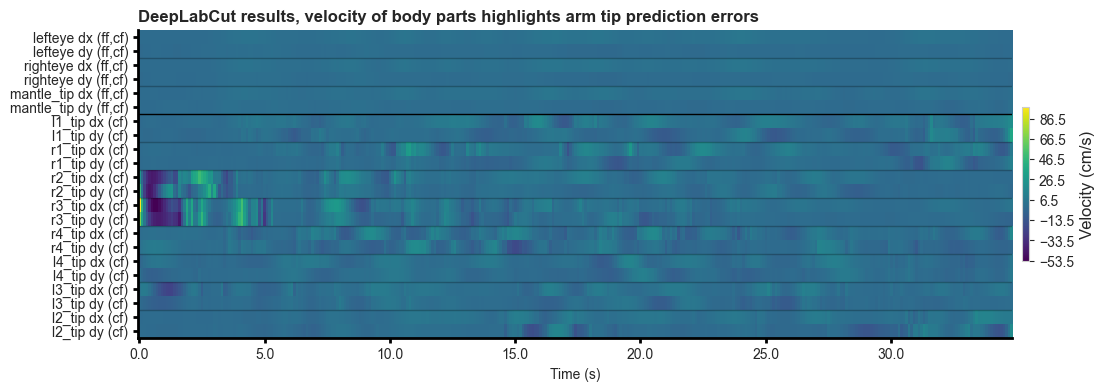

In [184]:
## make a heat map of the by body part velocities with y-axis as body part and x-axis as time
fig, ax = plt.subplots(1,1, figsize=(12,4))

heat_map = []
ylabs = []
yticks = []
n = 0
for xcol, ycol in zip(df_labels.columns[::3], df_labels.columns[1::3]):
    x,y = df_labels[xcol].values, df_labels[ycol].values
    dx, dy = np.diff(x), np.diff(y)
    heat_map.append(dx)
    heat_map.append(dy)

    if 'tip' in xcol[1] and 'mantle' not in xcol[1]:
        ylabs.append(xcol[1]+' dx'+' (cf)')
        ylabs.append(ycol[1]+' dy'+' (cf)')
    else:
        ylabs.append(xcol[1]+' dx'+' (ff,cf)')
        ylabs.append(ycol[1]+' dy'+' (ff,cf)')

    yticks.append(n)
    yticks.append(n+1)
    n += 2

heat_map = np.array(heat_map)
## convert to cm/s
fps = 10
y_value_correction_ = 2.54/20 ## convert pixels to cm; 20 pixels = 1inch = 2.54cm
heat_map = heat_map * y_value_correction_ * fps ## pixel/frame * cm/pixel * frame/s = cm/s

g = ax.imshow(heat_map, cmap='viridis', aspect='auto', interpolation='none')
## cbar
cbar_ticks = np.arange(np.min(heat_map), np.max(heat_map), 20)
cbar_title = 'Velocity (cm/s)'
cbar = fig.colorbar(g, ax=ax, orientation='vertical', fraction=0.05, pad=0.01, shrink=0.5)
cbar.set_ticks(cbar_ticks)
cbar.set_label(cbar_title, fontsize=12)

ax.set_yticks(yticks)
ax.set_yticklabels(ylabs)

for i, ytick in enumerate(yticks[1::2]):

    if ytick == 5:
        ax.axhline(y=ytick+0.5, color='black', linewidth=1, alpha=1)
    else:
        ax.axhline(y=ytick+0.5, color='black', linewidth=1, alpha=0.25)

xticks = np.arange(0, len(dx), 50)
xlabs = xticks/10

ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_xlabel('Time (s)')

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='black', width=2)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='black', width=2)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')

ax.set_title('DeepLabCut results, velocity of body parts highlights arm tip prediction errors', loc='left', fontsize=12, fontweight='bold')

path_fig = os.path.join(target_dir, 'dlc_tracking_results_velocity.png')
fig.savefig(path_fig, dpi=300, bbox_inches='tight', pad_inches=0.5)

plt.show(fig)
plt.close(fig)

In [164]:
xticks

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550])